# Getting Started

This section gives an overview over parsing, simulating and filtering models using **pydsge**. It also explains how to load and process data from an estimation.

In [1]:
# only necessary if you run this in a jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Parsing & simulating

Let us first import the base class and the example model:

In [2]:
from pydsge import * # imports eg. the DSGE class and the examples
yaml_file, data_file = example

The `example` here is nothing than a tuple containing the paths to two files. The first file to the example model file (as a string):


In [3]:
print(yaml_file)

/home/gboehl/github/pydsge/pydsge/examples/dfi.yaml


You can use your text editor of choice (which I hope is not Notepad) to open this file and have a look. It contains useful annotations and comments.

### Parsing ``*.yaml``-files

So lets parse this thing:

In [4]:
mod = DSGE.read(yaml_file)

Of course, if you would want to parse your own ``*.yaml`` model, you could easily do that by defining setting ``yaml_file = "/full/path/to/your/model.yaml"`` instead.

But, lets for now assume you are working with ``dfi.yaml``.

The ``mod`` object is now an instance of the `DSGE` class. 
Lets load the calibrated parameters from the file and instantize the transition function:

In [5]:
par = mod.set_par('calib')

Have a look at the functions `set_par` and `get_par` in the [modules documentation](https://pydsge.readthedocs.io/en/latest/modules.html#pydsge.parser.DSGE.get_par) if you want to experiment with the model. `get_par` gets you the current parameters:

In [6]:
# get a single parameter value, e.g. of "kappa"
mod.get_par('kappa')

0.17855151515151513

In [7]:
# or all parameters, for better readability as a dictionary
mod.get_par(asdict=True)

({'beta': 0.99,
  'theta': 0.66,
  'sigma': 1.5,
  'phi_pi': 1.7,
  'phi_y': 0.125,
  'rho': 0.8,
  'rho_u': 0.8,
  'rho_z': 0.9,
  'rho_r': 0.7,
  'sig_u': 0.5,
  'sig_z': 0.3,
  'sig_r': 0.3,
  'psi': 0.3,
  'nub': 0.1,
  'y_mean': 0.35,
  'pi_mean': 0.5,
  'elb_level': 0.07},
 {'kappa': 0.17855, 'eta': 2.11111, 'nu': 0.11111, 'x_bar': -0.9401})

The ``DSGE``-instance has many attributes that concentrate information and functions of the model. They are all listed in the [module documentation](https://pydsge.readthedocs.io/en/latest/modules.html#).

### Simulate IRFs

Let us use this to simulate a series of impulse responses:

In [8]:
shock_list = ('e_u', 4.0, 0) # (name, size, period)
X1, (L1, K1), _ = mod.irfs(shock_list, verbose=True)

Nice. For details see the ``irfs`` function. Lets plot it using the ``pplot`` plot function from the ``grgrlib`` library:

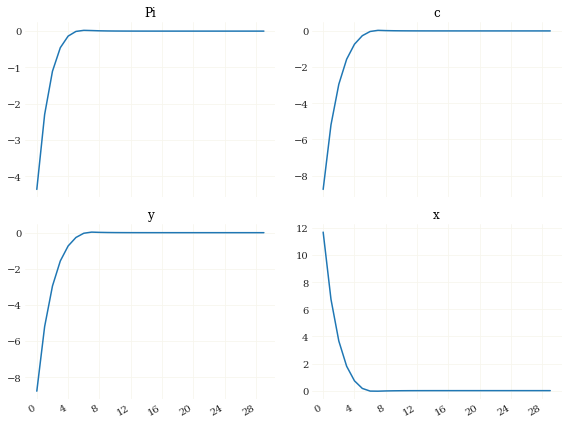

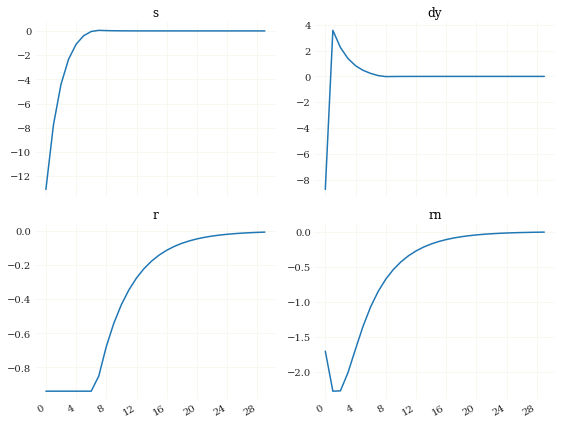

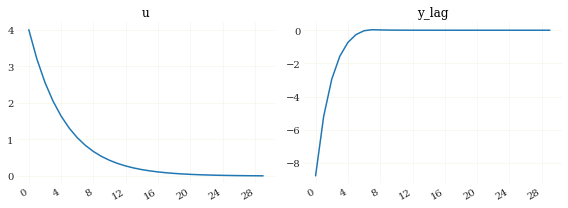

In [9]:
from grgrlib import pplot
figs, axs, _ = pplot(X1)

Btw, the ``L1, K1`` arrays contain the series of expected durations to/at the ZLB for each simulated period:

In [10]:
print(L1)
print(K1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[7. 6. 5. 4. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Well, lets see what changes if we increase the financial friction parameter `nub`...

In [11]:
mod.set_par('nub',.5)
X2 = mod.irfs(shock_list)[0] # this is still the same shock as defined above

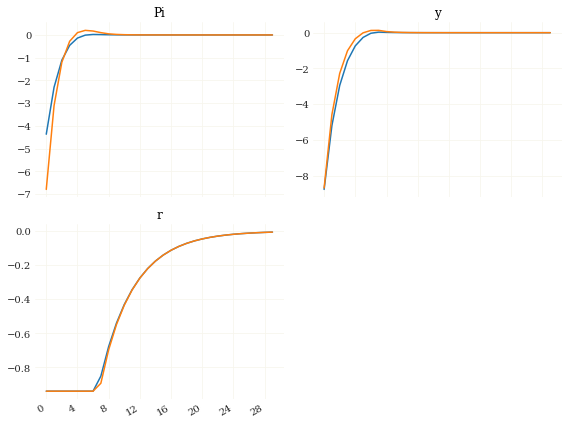

In [12]:
v = ['Pi','y','r'] # also, lets just look at Pi, y & r
figs, axs, _ = pplot((X1[v],X2[v])) # the output from mod.irfs can be indexed by the variable names!

### Sample from prior

Now lets assume that you have specified priors and wanted to know how flexible your model is in terms of impulse responses. The ``get_par`` function also allows sampling from the prior:

In [13]:
par0 = mod.get_par('prior', nsamples=100, verbose=True)

Adding parameters to the prior distribution...
   - theta as beta (0.5, 0.1). Init @ 0.7813, with bounds (0.2, 0.95)
   - sigma as normal (1.5, 0.375). Init @ 1.2312, with bounds (0.25, 3)
   - phi_pi as normal (1.5, 0.25). Init @ 1.7985, with bounds (1.0, 3)
   - phi_y as normal (0.125, 0.05). Init @ 0.0893, with bounds (0.001, 0.5)
   - rho_u as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho_r as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho_z as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho as beta (0.75, 0.1). Init @ 0.8, with bounds (0.5, 0.975)
   - sig_u as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.025, 5)
   - sig_r as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)
   - sig_z as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]

(prior_sample:) Sampling done. Check fails for 5.66% of the prior.


In [14]:
print(par0.shape)

(100, 17)


`par0` is an array with 100 samples of the 10-dimensional parameter vector. 
If you allow for ``verbose=True`` (which is the default) the function will also tell you how much of your prior is not implicitely trunkated by indetermined or explosive regions. 

Lets feed these parameters ``par0`` into our ``irfs()`` and plot it:

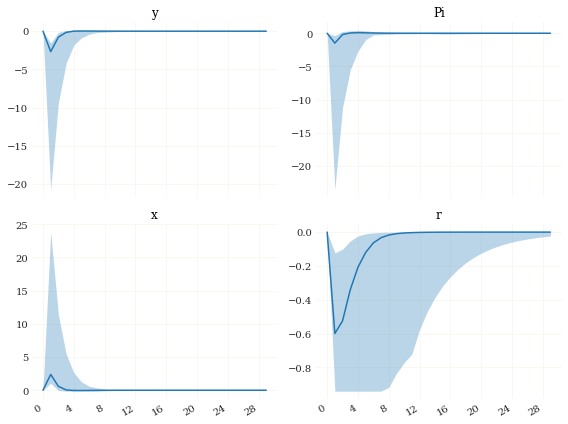

In [15]:
mod.set_par('calib')
shock_list = ('e_u', 3., 1) # (name, size, period)

X1, LK1, _ = mod.irfs(shock_list, par0, verbose=True)
v = mod.vix(('y','Pi','x','r')) # get the indices of these four variables
figs, axs, _ = pplot(X1[...,v], labels=mod.vv[v])

This gives you an idea on how tight your priors are. As the relatively strong negative demand shock kicks the economy to the ZLB, we observe a heavy economic contraction for some of the draws.

## Filtering & smoothing


This section treats how to load data, and do Bayesian filtering given a DSGE model.

### Load data


We have just seen how to parse the model. Parsing the data is likewise quite easy. It however assumes that you managed to put your data into pandas' ``DataFrame`` format. pandas knows many ways of loading your data file into a ``DataFrame``, see for example [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) on how to load a common ``*.csv`` file. 

Luckily I already prepared an example data file that is already well structured:

In [16]:
yaml_file, data_file = example
print(data_file)

/home/gboehl/github/pydsge/pydsge/examples/tsdata.csv


Again, this is just the path to a file that you can open and explore. I constructed the file such that I can already load the column ``data`` as a ``DateTimeIndex``, which makes things easier:

In [17]:
import pandas as pd

df = pd.read_csv(data_file, parse_dates=['date'], index_col=['date'])
df.index.freq = 'Q' # let pandas know that this is quartely data

print(df)

                GDP     Infl   FFR
date                              
1995-03-31  0.16884  0.60269  1.45
1995-06-30  0.13066  0.44765  1.51
1995-09-30  0.64258  0.42713  1.45
1995-12-31  0.45008  0.47539  1.43
1996-03-31  0.47113  0.50984  1.34
...             ...      ...   ...
2017-03-31  0.41475  0.49969  0.18
2017-06-30  0.54594  0.25245  0.24
2017-09-30  0.54391  0.51972  0.29
2017-12-31  0.48458  0.57830  0.30
2018-03-31  0.15170  0.48097  0.36

[93 rows x 3 columns]


Now you should give you an idea of how the data looks like. The frame contains the time series of US output growth, inflation, and the FFR from 1995Q1 to 2018Q1.

It is generally a good idea to adjust the series of observables such, that they are within reach of the model. As the model can not simulate values below the ZLB, we should adjust the series of the interest rate accordingly:

In [18]:
# adjust elb
zlb = mod.get_par('elb_level')
rate = df['FFR']
df['FFR'] = np.maximum(rate,zlb)

In [19]:
mod.load_data(df)

,GDP,Infl,FFR
date,,,
1995-03-31,0.16884,0.60269,1.45
1995-06-30,0.13066,0.44765,1.51
1995-09-30,0.64258,0.42713,1.45
1995-12-31,0.45008,0.47539,1.43
1996-03-31,0.47113,0.50984,1.34
...,...,...,...
2017-03-31,0.41475,0.49969,0.18
2017-06-30,0.54594,0.25245,0.24
2017-09-30,0.54391,0.51972,0.29


This automatically selects the obsevables you defined in the ``*.yaml`` and puts them in the ``mod.data`` object. Note that it will complain if it can't find these observables or if they are named differently. So, that's all we want from now.

### Run filter

We now want to use a Bayesian Filter to smooth out the hidden states of the model. As the example data sample contains the Zero-lower bound period and the solution method is able to deal with that, we should use a nonlinear filter such as the *Transposed Ensemble Kalman Filter (TEnKF)*. This filter is a hybrid between the Kalman Filter and the Particle Filter, we hence have to define the number of particles. For small problems as the one here, a smaller number would be sufficient, but since everything goes so fast, let us chose 500:

In [20]:
mod.set_par('calib') # important to reset the parameters as they are still random from previous sampling
mod.create_filter(N=500, ftype='TEnKF', seed=0)

The **TEnKF** is the default filter, so specifying ``ftype`` would not even have been necessary. The filter got most of the necessary information (innovation covariance, observation function etc) from the ``*.yaml``. What remains to be specified is the measurement noise. The covariance matrix of the measurement errors are stored as ``mod.filter.R``. Luckily, there is a function that creates a diagonal matrix with its diagonal equal to the fraction `a` of the standard deviation of the respective time series, as it is frequently done:

In [21]:
mod.filter.R = mod.create_obs_cov(1e-1)

Here, `a=1e-1`. As one last thing before running the filter, we would like to set the ME of the FFR very low as this can be measured directly (note that we can not set it to zero due to numerical reasons, but we can set it sufficiently close).

In [22]:
# lets get the index of the FFR
ind = mod.observables.index('FFR')
# set ME of the FFR to very small value
mod.filter.R[ind,ind] = 1e-4

``mod.observables`` contains all the observables. See the [module documentation](https://pydsge.readthedocs.io/en/latest/modules.html#) for more useful class variables. But lets start the filter already!

In [23]:
mod.set_par('calib')
FX = mod.run_filter(verbose=True, smoother=True)

[run_filter:]   Filtering done in 0.53s.


``smoother=True`` also directly runs the TEnKF-RTS-Smoother. ``FX`` now contains the states. Lets have a look:

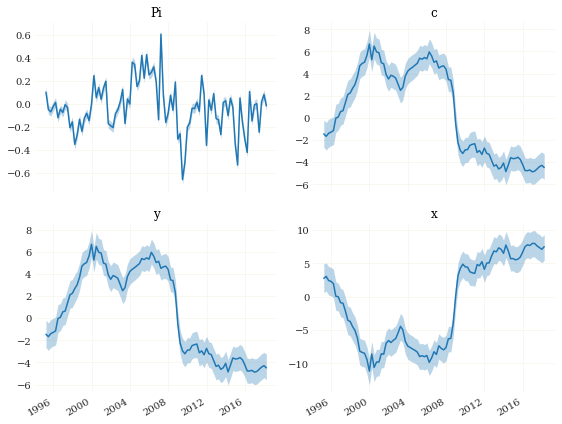

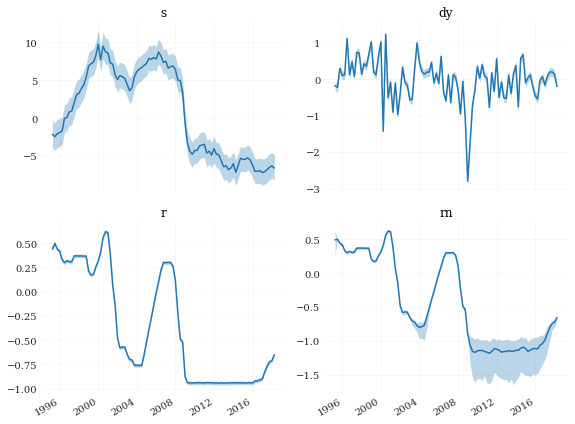

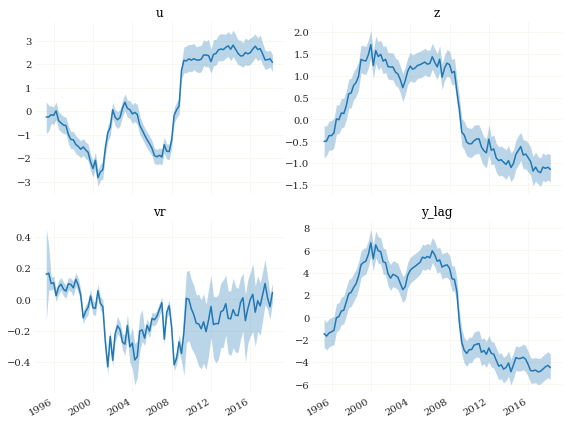

In [24]:
fig, ax, _ = pplot(FX, mod.data.index, labels=mod.vv)

We can also have a look at the implied observables. The function ``mod.obs()``
is the observation function, implemented to work on particle clouds (such as ``FX``):


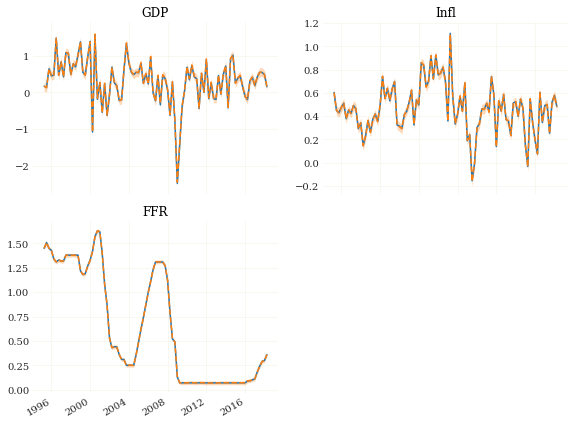

In [25]:
FZ = mod.obs(FX)
fig, ax, _ = pplot((mod.Z, FZ), mod.data.index, labels=mod.observables, styles=('-','--'))

That looks perfect. Note that these particles/ensemble members/"dots" yet do not *fully* obey the nonlinearity of the transition function but contain approximation errors. To get rid of those we need adjustment smoothing.

## Tools for Model Analysis

This section shows how to obtain batches of smoothed shocks that can be used to simulate counterfactuals, historic decompositions, and variance decompositions.

### Extracting/smoothed shocks

**pydsge** uses the Nonliear Path-Adjustment Smoother (NPAS) implemented in my [**econsieve**](https://econsieve.readthedocs.io/en/latest/readme.html) package to extract the series of shocks given a transition function and a particle cloud. Keep in mind that in order to account for filtering uncertainty, you need to draw many series from the same particle cloud. For illustrative purposes, lets start with a sample of 20 (which is very likely to be too small):

In [26]:
mod.set_par('calib') # just to be sure
epd = mod.extract(nsamples=20)

100%|██████████| 20/20 [00:28<00:00,  1.40s/ sample(s)]


The `mod.extract` function returns a dictionary (here named `epd`). It contains the parameters of each sample (here, they are all the same), the NPA-smoothed means and covariances, the implied series of observables, and the series of smoothed shock residuals. The `flags` entry contains potential error messages from NPA-smoothing.

In [27]:
epd.keys()

dict_keys(['pars', 'init', 'resid', 'flags'])

### Simulating counterfactuals

Lets use these residuals to simulate counterfactuals. For that, we will use the function `mod.simulate()`, which takes the dictionary of extracted shocks as inputs, potentially together with a mask that will be applied to these shocks to alter them. Let me first create such mask:

In [28]:
msk0 = mod.mask
print(msk0)

            e_z  e_u  e_r
date                     
1995-03-31  NaN  NaN  NaN
1995-06-30  NaN  NaN  NaN
1995-09-30  NaN  NaN  NaN
1995-12-31  NaN  NaN  NaN
1996-03-31  NaN  NaN  NaN
...         ...  ...  ...
2016-12-31  NaN  NaN  NaN
2017-03-31  NaN  NaN  NaN
2017-06-30  NaN  NaN  NaN
2017-09-30  NaN  NaN  NaN
2017-12-31  NaN  NaN  NaN

[92 rows x 3 columns]


As you can see this is a dataframe equivalent to the series of shocks, but filled with eps. The logic is simple: whenever the mask is `NaN`, the original shock value for the respective period will be used. If the mask is other then `Nan`, the mask will be used. 

Let's give this a try by creating a mask that will set all demand shocks (`e_r`) after 2008Q4 equal zero. This can be interpreted as a counterfactual analysis to study the effects of monetary policy shocks and forward guidance during the ZLB period:

In [29]:
msk0['e_r']['2008Q4':] = 0 

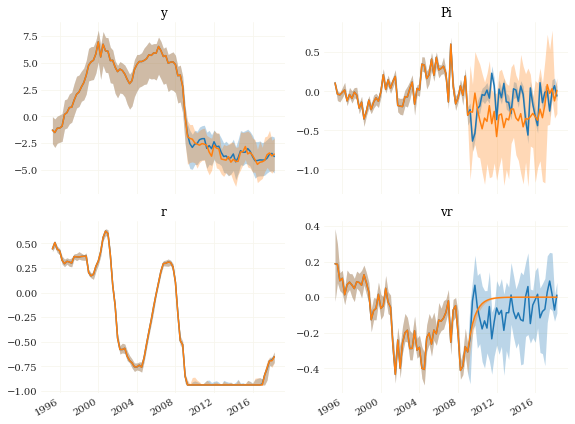

In [30]:
cfs0 = mod.simulate(epd, mask=None)[0] # simulate using original shocks 
cfs1 = mod.simulate(epd, mask=msk0)[0] # simulate using the masked shocks without MP

v = mod.vix(('y','Pi','r','vr'))
fig, ax, _ = pplot((cfs0[...,v], cfs1[...,v]), mod.data.index, labels=mod.vv[v])

Interesting. According to this toy model, the course of the ZLB is completely independent of monetary policy, yet the policy shocks at the ZLB are able to stimulate inflation through the forward guidance channel. 

### Historic decompositions

We can also use the `epd` dictionary to create historic shock decompositions:

100%|██████████| 20/20 [00:00<00:00, 134.20 sample(s)/s]


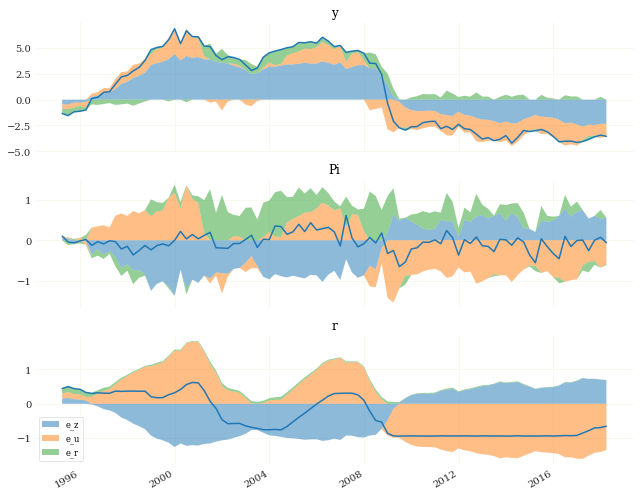

In [31]:
hd, means = mod.nhd(epd)

v = ['y','Pi','r'] # lets only look at these three here

hd = [h[v] for h in hd] # the `hd` object is again a pandas dataframe, so we can index with variable names
hmin, hmax = sort_nhd(hd) # devide into positive and negative contributions

from grgrlib import figurator # the figurator is another nice tool simplifying plotting
fig, ax = figurator(3,1, figsize=(9,7))

pplot(hmax, mod.data.index, labels=v, alpha=.5, ax=ax)
pplot(hmin, mod.data.index, labels=v, alpha=.5, ax=ax, legend=mod.shocks)
pplot(means[v], mod.data.index, labels=v, ax=ax)

fig[0].tight_layout()
_ = ax[2].legend(loc=3)